In [3]:
#Import packages used below
import numpy as np
import pandas as pd
##pip3 install multiprocess
import multiprocessing as mp 
import matplotlib.pyplot as plt
import itertools
import copy
import DeferredAcceptance as da


import warnings
import time
import pickle

MP: woman 87 and man 104
woman: 87 held: 104, her 90th preference
is now matched with man 95, her 87th preference
Rejection Chain Length 8
 
MP: woman 101 and man 95
woman: 101 held: 95, her 74th preference
is now matched with man 104, her 51th preference
Rejection Chain Length 8
 
MP: woman 102 and man 111
woman: 102 held: 111, her 107th preference
is now matched with man 121, her 73th preference
Rejection Chain Length 29
 
MP: woman 113 and man 131
woman: 113 held: 131, her 109th preference
is now matched with man 115, her 93th preference
Rejection Chain Length 77
 
MP: woman 114 and man 121
woman: 114 held: 121, her 85th preference
is now matched with man 101, her 74th preference
Rejection Chain Length 29
 
MP: woman 118 and man 101
woman: 118 held: 101, her 90th preference
is now matched with man 111, her 72th preference
Rejection Chain Length 29
 
MP: woman 148 and man 115
woman: 148 held: 115, her 127th preference
is now matched with man 131, her 98th preference
Rejection Chain L

,Woman ID,I. Match,I. PrefRank,N. Match,N. PrefRank,improvement,Chain Length
0,87,104,90,95,87,3,8
0,101,95,74,104,51,23,8
0,102,111,107,121,73,34,29
0,113,131,109,115,93,16,77
0,114,121,85,101,74,11,29
0,118,101,90,111,72,18,29
0,148,115,127,131,98,29,77
0,179,181,142,149,133,9,7
0,187,203,173,201,170,3,47
0,191,149,153,181,151,2,7


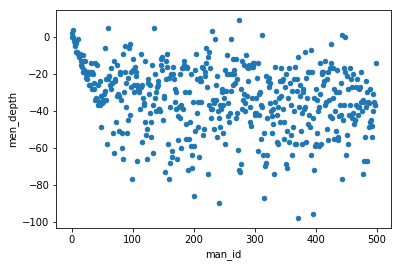

In [4]:
n = 500
sigma_fract = .1



#define rank lists
men_source = da.preflists(n, sigma_fract)
women_source = da.preflists(n, sigma_fract)

men_long = copy.deepcopy(men_source[2])
men = copy.deepcopy(men_source[0])
men_as_suiteds = copy.deepcopy(men_source[1])
men_as_suiteds_long = copy.deepcopy(men_source[3])

women = copy.deepcopy(women_source[1])
women_long = copy.deepcopy(women_source[1])
women_as_suitors = copy.deepcopy(women_source[0])
women_as_suitors_long = copy.deepcopy(women_source[2])


#matching
MoSm_long = da.GSDA(men_long, women_long)
#matching with women proposing
#print(men_as_suiteds_long)
#print(women_as_suitors_long)
MoSm_WP_long = da.GSDA(women_as_suitors_long, men_as_suiteds_long)

#print("MP")
#print(MoSm_long)
#print("WP")
#print(MoSm_WP_long)
#long_core_size
core_same_long = 0
core_diff_long = 0

#initialize dataframe of rejection chains
rejectionChainVars = ['Woman ID', 'I. Match', 'I. PrefRank', 'N. Match', 'N. PrefRank','improvement', 'Chain Length']
rejectionChains = pd.DataFrame([], columns=rejectionChainVars) 
for k, v in MoSm_long.items():
    if MoSm_WP_long.get(women_as_suitors_long[v.id]).id == k.id :
        core_same_long += 1
    else:
        core_diff_long += 1
        print("MP: woman " + str(v.id) + " and man " + str(k.id))
        
        ##See how long the rejection chain is:
        #first make new copy of the suiteds and sutors objects 
        #(note that these objects already have the number of rejections etc coded into them)
        men_long_cp = copy.deepcopy(men_long)
        women_long_cp = copy.deepcopy(women_long)
        
        #examine the woman:
        woman_id = copy.deepcopy(women_long_cp[v.id].id)
        woman_init_match = copy.deepcopy(women_long_cp[v.id].held.id)
        woman_init_prefRank = copy.deepcopy(women_long_cp[v.id].prefList.index(women_long_cp[v.id].held.id))
        print("woman: "+ str(women_long_cp[v.id].id) + " held: "+ str(women_long_cp[v.id].held.id) +
              ", her " + str(women_long_cp[v.id].prefList.index(women_long_cp[v.id].held.id)) +"th preference")
        
        #truncate woman's pref list
        women_long_cp[v.id].prefList = women_long_cp[v.id].prefList[:women_long_cp[v.id].prefList.index(women_long_cp[v.id].held.id)]
        
        
        #move "held" man to "current suitors"
        women_long_cp[v.id].currentSuitors |= set([women_long_cp[v.id].held])
        women_long_cp[v.id].held = None
        
        #reject man/setup resumed DA
        unassigned = set()
        for suited in women_long_cp:
            unassigned |= suited.reject()
        for suitor in unassigned:
            suitor.rejections += 1
            
        
        #run DA, counting steps
        rejectionChain = 1
        
        while len(unassigned) > 0:
            for suitor in unassigned:
                next_proposal = suitor.preference()
                if next_proposal != None:
                    women_long_cp[suitor.preference()].currentSuitors.add(suitor)
            unassigned = set()
            for suited in women_long_cp:
                unassigned |= suited.reject()

            for suitor in unassigned:
                suitor.rejections += 1
        
            rejectionChain += 1
        
        woman_new_match = copy.deepcopy(women_long_cp[v.id].held.id)
        woman_new_prefRank = copy.deepcopy(women_long_cp[v.id].prefList.index(women_long_cp[v.id].held.id))
        print("is now matched with man " 
              + str(women_long_cp[v.id].held.id)+ ", her " + 
              str(women_long_cp[v.id].prefList.index(women_long_cp[v.id].held.id)) 
              +"th preference")
        print("Rejection Chain Length " +  str(rejectionChain))                      
        print(" ")

        rejectionChains = rejectionChains.append(pd.DataFrame([[woman_id, woman_init_match , woman_init_prefRank, woman_new_match, woman_new_prefRank,woman_init_prefRank - woman_new_prefRank, rejectionChain ]], columns=rejectionChainVars) )

        
assert core_same_long + core_diff_long == n
core_size_long = core_diff_long/ n

print("Core Difference: " + str(core_diff_long))

list_depth = pd.DataFrame(men_long, columns=['Men'])
def man_as_id(row):
    return(row['Men'].id)
def ranklist_depth(row):
    man = row['Men']
    manid = row['Men'].id
    man_got = MoSm_long.get(man).id
    #print(type(man_got))
    man_got_rank = man.prefList.index(man_got)
    return(man_got_rank - manid)
list_depth['man_id'] = list_depth.apply(lambda row: man_as_id(row), axis=1)
list_depth['men_depth'] =  list_depth.apply(lambda row: ranklist_depth(row), axis=1)

list_depth.plot.scatter('man_id', 'men_depth')
rejectionChains

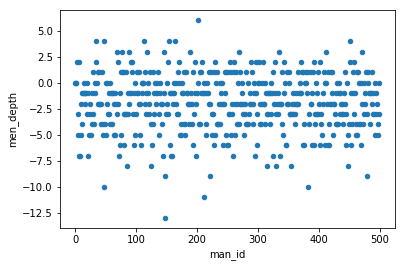

In [6]:
list_depth = pd.DataFrame(men_long, columns=['Men'])
def man_as_id(row):
    return(row['Men'].id)
def ranklist_depth(row):
    man = row['Men']
    manid = row['Men'].id
    man_got = MoSm_long.get(man).id
    #print(type(man_got))
    man_got_rank = man.prefList.index(man_got)
    return(man_got_rank - manid)
list_depth['man_id'] = list_depth.apply(lambda row: man_as_id(row), axis=1)
list_depth['men_depth'] =  list_depth.apply(lambda row: ranklist_depth(row), axis=1)

list_depth.plot.scatter('man_id', 'men_depth')


In [5]:
list_depth

,Men,man_id,men_depth
0,0,0,2
1,1,1,0
2,2,2,0
3,3,3,4
4,4,4,-2
5,5,5,-5
6,6,6,-4
7,7,7,-3
8,8,8,-8
9,9,9,-8


In [125]:
import csv
with open('MoSm_WP_long.csv', 'w', newline='') as csvfile:
    w = csv.writer(csvfile, delimiter=',',
                quotechar='|', quoting=csv.QUOTE_MINIMAL)
    w.writerow(['Man', 'WP Woman'])
    for key, val in MoSm_WP_long.items():
             w.writerow([val, key])

with open('MoSm_long.csv', 'w', newline='') as csvfile:
    w = csv.writer(csvfile, delimiter=',',
                quotechar='|', quoting=csv.QUOTE_MINIMAL)
    w.writerow(['Man', 'MP Woman'])
    for key, val in MoSm_long.items():
             w.writerow([key, val])           

In [134]:
with open('men_preflists.csv', 'w', newline='') as csvfile:
        w = csv.writer(csvfile, delimiter=',',
                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for man in men_long:
            w.writerow([man.id] + list([man.prefList]) )
            
with open('woman_preflists.csv', 'w', newline='') as csvfile:
        w = csv.writer(csvfile, delimiter=',',
                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for man in women_long:
            w.writerow([man.id, man.prefList])

In [139]:
#MoSm_long.get(men_long[0])

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 24,
 23,
 25,
 27,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 44,
 46,
 48,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 66,
 68,
 70,
 69,
 72,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 None)

In [5]:
unmatched = []
len(unmatched)

0

In [5]:
deliverable_simulation = sim_short(n =50,
    sigma_fract = 0.001,
    list_length = 15,
    match_threshold = .99,
    run_no = 4)

deliverable_simulation


[50,
 0.001,
 15,
 0.99,
 4,
 0.0,
 0.7,
 0.64,
 0.6621774193548388,
 0.0,
 0.84,
 0.0,
 0.0]

In [6]:
bob = da.Suited(1, [2, 3, 4])
bob.prefList.index(2)

0

In [7]:
a = np.nan
type(a)

float

In [8]:
# an intermediate simulation program to allow me to parallelize the calculations
def simulate(run_no, size):
    #Note that, as noted above, I define the parameters here, within a program. This is bad.
    #Also note that the code in this block changes a bit as I add to the "results" object without 
    #re-running the entire simulation
    sigmas = [.001,.05, .1]
    #Slopyness ends here
    
    result = pd.DataFrame()
    for sigma_fraction in sigmas:
        start = time.process_time()
        result = result.append(pd.DataFrame(sim_short(
            size ,
            sigma_fraction ,
            list_length = 15,
            match_threshold = .99,
            run_no = run_no)).T)

        result_file_str = "/Users/tylerhoppenfeld/Documents/MarketDesign/" +  str(size)+ "_" + str(sigma_fraction) + "_" + str(run_no)
        with open(result_file_str, "wb") as f:
            pickle.dump(result, f)
        print("run: " + str(run_no) + ", N: " + str(size) + ", sigma: " + str(sigma_fraction) + " done, took: " + str(time.process_time()- start))
    
    return result

In [ ]:
#warnings.filterwarnings("error")
warnings.resetwarnings()
runs = 50


runlist10 = np.concatenate((np.expand_dims(list(range(0,runs)), axis = 1), [[10]]*runs), axis = 1)
runlist50 = np.concatenate((np.expand_dims(list(range(0,runs)), axis = 1), [[50]]*runs), axis = 1)
runlist500 = np.concatenate((np.expand_dims(list(range(0,runs)), axis = 1), [[500]]*runs), axis = 1)
runlist1500 = np.concatenate((np.expand_dims(list(range(0,runs)), axis = 1), [[1500]]*runs), axis = 1)

runlista = np.concatenate((runlist10 , runlist50), axis = 0)
runlistb = np.concatenate((runlist500 , runlist1500), axis = 0)
runlist = np.concatenate((runlista, runlistb), axis = 0)

pool = mp.Pool(processes = (mp.cpu_count()))
results10 = pool.starmap(simulate, runlist10)
pool.close()
pool.join()

pool = mp.Pool(processes = (mp.cpu_count()))
results50 = pool.starmap(simulate, runlist50)
pool.close()
pool.join()

pool = mp.Pool(processes = (mp.cpu_count()))
results500 = pool.starmap(simulate, runlist500)
pool.close()
pool.join()

pool = mp.Pool(processes = (mp.cpu_count()))
results1500 = pool.starmap(simulate, runlist1500)
pool.close()
pool.join()


results10_df = pd.concat(results10, sort=True, axis = 0)
results50_df = pd.concat(results50, sort=True, axis = 0)
results500_df = pd.concat(results500, sort=True, axis = 0)
results1500_df = pd.concat(results150, sort=True, axis = 0)
results_df = pd.concat([results10_df, results50_df, results500_df, results1500_df])

results_df = pd.concat(results, sort=True, axis = 0)

results_df.columns = ["n", 
    "sigma_fract", 
    "list_length",
    "match_threshold", 
    "run_no", 
    "optimal_fraction", 
    "unmatched_fraction", 
    "average_unmatched_pctl", 
    "avg_missed_by_pctl",
    "long_short_same_fract", 
    "avg_missed_by_no_unm_pctl",
    "core_size", 
    "core_size_long"]


             
results_df

run: 12, N: 10, sigma: 0.001 done, took: 3.799112
run: 0, N: 10, sigma: 0.001 done, took: 3.833654
run: 4, N: 10, sigma: 0.001 done, took: 3.815524
run: 8, N: 10, sigma: 0.001 done, took: 3.80451
run: 4, N: 10, sigma: 0.05 done, took: 3.498542
run: 8, N: 10, sigma: 0.05 done, took: 3.5298380000000003
run: 12, N: 10, sigma: 0.05 done, took: 3.523596
run: 0, N: 10, sigma: 0.05 done, took: 3.515386
run: 8, N: 10, sigma: 0.1 done, took: 3.573836
run: 4, N: 10, sigma: 0.1 done, took: 3.5390320000000006
run: 0, N: 10, sigma: 0.1 done, took: 3.517211999999999
run: 12, N: 10, sigma: 0.1 done, took: 3.5436179999999995
run: 9, N: 10, sigma: 0.001 done, took: 3.604488
run: 13, N: 10, sigma: 0.001 done, took: 3.5978220000000007
run: 1, N: 10, sigma: 0.001 done, took: 3.6348020000000005
run: 5, N: 10, sigma: 0.001 done, took: 3.618556
run: 5, N: 10, sigma: 0.05 done, took: 3.6034599999999983
run: 13, N: 10, sigma: 0.05 done, took: 3.6155240000000006
run: 9, N: 10, sigma: 0.05 done, took: 3.60488999

run: 48, N: 10, sigma: 0.001 done, took: 3.525677999999999
run: 48, N: 10, sigma: 0.05 done, took: 3.4385739999999885
run: 48, N: 10, sigma: 0.1 done, took: 3.763448000000011
run: 49, N: 10, sigma: 0.001 done, took: 3.9444699999999955
run: 49, N: 10, sigma: 0.05 done, took: 3.3178680000000043
run: 49, N: 10, sigma: 0.1 done, took: 3.253157999999985
run: 0, N: 50, sigma: 0.001 done, took: 4.12344
run: 12, N: 50, sigma: 0.001 done, took: 4.055688
run: 8, N: 50, sigma: 0.001 done, took: 4.09523
run: 4, N: 50, sigma: 0.001 done, took: 4.090486
run: 12, N: 50, sigma: 0.05 done, took: 3.873234
run: 8, N: 50, sigma: 0.05 done, took: 3.8509279999999997
run: 4, N: 50, sigma: 0.05 done, took: 3.8566599999999998
run: 0, N: 50, sigma: 0.05 done, took: 3.9235500000000005
run: 4, N: 50, sigma: 0.1 done, took: 3.6693539999999993
run: 12, N: 50, sigma: 0.1 done, took: 3.682984000000001
run: 8, N: 50, sigma: 0.1 done, took: 3.6211919999999997
run: 0, N: 50, sigma: 0.1 done, took: 3.6615040000000008
run

run: 35, N: 50, sigma: 0.05 done, took: 3.7494020000000035
run: 47, N: 50, sigma: 0.05 done, took: 3.754877999999991
run: 39, N: 50, sigma: 0.05 done, took: 3.7379119999999944
run: 35, N: 50, sigma: 0.1 done, took: 3.7125139999999988
run: 39, N: 50, sigma: 0.1 done, took: 3.7157840000000135
run: 43, N: 50, sigma: 0.1 done, took: 3.715665999999999
run: 47, N: 50, sigma: 0.1 done, took: 3.6927239999999983
run: 48, N: 50, sigma: 0.001 done, took: 3.5325359999999932
run: 48, N: 50, sigma: 0.05 done, took: 3.5943499999999915
run: 48, N: 50, sigma: 0.1 done, took: 3.7970439999999996
run: 49, N: 50, sigma: 0.001 done, took: 3.676885999999996
run: 49, N: 50, sigma: 0.05 done, took: 3.810200000000009
run: 49, N: 50, sigma: 0.1 done, took: 3.9580840000000137
run: 4, N: 500, sigma: 0.001 done, took: 930.5969200000001
run: 0, N: 500, sigma: 0.001 done, took: 934.705728
run: 8, N: 500, sigma: 0.001 done, took: 938.244698
run: 12, N: 500, sigma: 0.001 done, took: 937.112144
run: 0, N: 500, sigma: 0.

run: 34, N: 500, sigma: 0.1 done, took: 631.221411999999
run: 42, N: 500, sigma: 0.1 done, took: 609.2253539999983
run: 38, N: 500, sigma: 0.1 done, took: 667.3804380000001
run: 46, N: 500, sigma: 0.1 done, took: 705.7927820000004
run: 35, N: 500, sigma: 0.001 done, took: 1419.0748600000006
run: 43, N: 500, sigma: 0.001 done, took: 1423.8146779999988
run: 39, N: 500, sigma: 0.001 done, took: 1425.3516259999997
run: 47, N: 500, sigma: 0.001 done, took: 1409.4942700000029
run: 35, N: 500, sigma: 0.05 done, took: 963.2610779999995
run: 43, N: 500, sigma: 0.05 done, took: 966.823174000001
run: 39, N: 500, sigma: 0.05 done, took: 958.9784720000025
run: 47, N: 500, sigma: 0.05 done, took: 950.9572880000014
run: 35, N: 500, sigma: 0.1 done, took: 673.8570680000012
run: 43, N: 500, sigma: 0.1 done, took: 678.9787399999987
run: 39, N: 500, sigma: 0.1 done, took: 702.4371099999989
run: 47, N: 500, sigma: 0.1 done, took: 750.9010419999977
run: 48, N: 500, sigma: 0.001 done, took: 1436.72798200000

In [9]:
import os

directory_in_str = "/Users/tylerhoppenfeld/Documents/MarketDesign/Results"
directory = os.fsencode(directory_in_str)

def compile(file):
    filepath = "/Users/tylerhoppenfeld/Documents/MarketDesign/Results/" + file
    print(filepath)
    try:
        with open(filepath, "rb") as f:
            result = pickle.load(f)
    except:
        result = pd.DataFrame()

        
    return result

results_df = pd.DataFrame()

for file in os.listdir(directory):
    result = compile(file.decode('utf-8'))
    results_df = results_df.append(result)

    
results_df.columns = ["n", 
    "sigma_fract", 
    "list_length",
    "match_threshold", 
    "run_no", 
    "optimal_fraction", 
    "unmatched_fraction", 
    "average_unmatched_pctl", 
    "avg_missed_by_pctl",
    "long_short_same_fract", 
    "avg_missed_by_no_unm_pctl",
    "core_size", 
    "core_size_long"]    
results_df

/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_17
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.001_10.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_28
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.001_39
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_10
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.05_38
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_26
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.001_30
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_19
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.05_31
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.001_21
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.05_36
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.001_37
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_44.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_37
/User

/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_17
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.05_2
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_18.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_30.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_24.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_10
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_19
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.1_35
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.05_35
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_26
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_35
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.1_32
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_21
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_9
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.05_32
/Users/tylerhop

/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_16.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.001_9
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.05_48
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.001_9
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.05_48
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_19.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_25.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/50_0.1_48
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_31.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_30.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.001_45
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_24.pkl
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.05_23
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/500_0.1_30
/Users/tylerhoppenfeld/Documents/MarketDesign/Results/10_0.1_18.pkl


,n,sigma_fract,list_length,match_threshold,run_no,optimal_fraction,unmatched_fraction,average_unmatched_pctl,avg_missed_by_pctl,long_short_same_fract,avg_missed_by_no_unm_pctl,core_size,core_size_long
0,50.0,0.001,15.0,0.99,17.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000
0,10.0,0.001,15.0,0.99,10.0,1.0,0.000,NaN,NaN,1.0,NaN,0.000,0.000
0,50.0,0.001,15.0,0.99,28.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000
0,500.0,0.001,15.0,0.99,39.0,0.0,0.968,0.513186,0.516127,0.0,0.983125,0.000,0.000
0,50.0,0.001,15.0,0.99,10.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000
0,50.0,0.001,15.0,0.99,38.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000
0,50.0,0.050,15.0,0.99,38.0,0.0,0.620,0.680000,0.701612,0.0,0.801053,0.040,0.040
0,50.0,0.001,15.0,0.99,26.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000
0,500.0,0.001,15.0,0.99,30.0,0.0,0.968,0.514707,0.516885,0.0,0.983125,0.000,0.000
0,50.0,0.001,15.0,0.99,19.0,0.0,0.700,0.640000,0.662177,0.0,0.840000,0.000,0.000


In [31]:
results_df.groupby(['n', 'sigma_fract']).agg({'unmatched_fraction':np.mean, 'optimal_fraction':np.mean, 'avg_missed_by_pctl':np.mean})


unmatched_fraction  optimal_fraction  avg_missed_by_pctl
n     sigma_fract                                                          
10.0  0.001                   0.00000               1.0                 NaN
      0.050                   0.00000               1.0                 NaN
      0.100                   0.00000               1.0                 NaN
50.0  0.001                   0.70000               0.0            0.662177
      0.050                   0.64120               0.0            0.690137
      0.100                   0.58800               0.0            0.716192
500.0 0.001                   0.96856               0.0            0.516417
      0.050                   0.89532               0.0            0.562389
      0.100                   0.83164               0.0            0.610470

In [39]:
import pickle

bob = pickle.load( open("/Users/tylerhoppenfeld/Documents/MarketDesign/results_df.pkl", "rb"))
bob

,n,sigma_fract,list_length,match_threshold,run_no,optimal_fraction,long_short_same_fract,core_size,core_size_long
0,10.0,0.001,15.0,0.99,0.0,1.000000,1.0,0.000000,0.000000
0,10.0,0.050,15.0,0.99,0.0,1.000000,1.0,0.000000,0.000000
0,10.0,0.100,15.0,0.99,0.0,1.000000,1.0,0.000000,0.000000
0,50.0,0.001,15.0,0.99,0.0,0.300000,0.0,0.000000,0.000000
0,50.0,0.050,15.0,0.99,0.0,0.340000,0.0,0.040000,0.080000
0,50.0,0.100,15.0,0.99,0.0,0.400000,0.0,0.000000,0.160000
0,500.0,0.001,15.0,0.99,0.0,0.030000,0.0,0.000000,0.000000
0,500.0,0.050,15.0,0.99,0.0,0.104000,0.0,0.000000,0.068000
0,500.0,0.100,15.0,0.99,0.0,0.172000,0.0,0.000000,0.046000
0,1500.0,0.001,15.0,0.99,0.0,0.012000,0.0,0.001333,0.042667


In [32]:
results_df.columns = ["n", 
    "sigma_fract", 
    "list_length",
    "match_threshold", 
    "run_no", 
    "optimal_fraction", 
    "long_short_same_fract", 
    "core_size", 
    "core_size_long"]
results_df

,n,sigma_fract,list_length,match_threshold,run_no,optimal_fraction,long_short_same_fract,core_size,core_size_long
0,10.0,0.001,15.0,0.99,0.0,1.00,1.0,0.00,0.00
0,10.0,0.005,15.0,0.99,0.0,1.00,1.0,0.00,0.00
0,10.0,0.010,15.0,0.99,0.0,1.00,1.0,0.00,0.00
0,10.0,0.050,15.0,0.99,0.0,1.00,1.0,0.00,0.00
0,10.0,0.100,15.0,0.99,0.0,1.00,1.0,0.00,0.00
0,50.0,0.001,15.0,0.99,0.0,0.30,0.0,0.00,0.00
0,50.0,0.005,15.0,0.99,0.0,0.30,0.0,0.00,0.00
0,50.0,0.010,15.0,0.99,0.0,0.30,0.0,0.00,0.00
0,50.0,0.050,15.0,0.99,0.0,0.34,0.0,0.00,0.04
0,50.0,0.100,15.0,0.99,0.0,0.44,0.0,0.00,0.18


In [40]:
results_df.groupby(['n', 'sigma_fract' , 'list_length', 'match_threshold']).mean()

run_no  optimal_fraction  \
n      sigma_fract list_length match_threshold                             
10.0   0.001       15.0        0.99               24.5          1.000000   
       0.050       15.0        0.99               24.5          1.000000   
       0.100       15.0        0.99               24.5          1.000000   
50.0   0.001       15.0        0.99               24.5          0.300000   
       0.050       15.0        0.99               24.5          0.354400   
       0.100       15.0        0.99               24.5          0.412800   
500.0  0.001       15.0        0.99               24.5          0.031280   
       0.050       15.0        0.99               24.5          0.104400   
       0.100       15.0        0.99               24.5          0.168840   
1500.0 0.001       15.0        0.99               24.5          0.011827   
       0.050       15.0        0.99               24.5          0.084120   
       0.100       15.0        0.99               24.5          0.142720   

                                                long_short_same_fract  \
n      sigma_fract list_length match_threshold                          
10.0   0.001       15.0        0.99                               1.0   
       0.050       15.0        0.99                               1.0   
       0.100       15.0        0.99                               1.0   
50.0   0.001       15.0        0.99                               0.0   
       0.050       15.0        0.99                               0.0   
       0.100       15.0        0.99                               0.0   
500.0  0.001       15.0        0.99                               0.0   
       0.050       15.0        0.99                               0.0   
       0.100       15.0        0.99                               0.0   
1500.0 0.001       15.0        0.99                               0.0   
       0.050       15.0        0.99                               0.0   
       0.100       15.0        0.99                               0.0   

                                                core_size  core_size_long  
n      sigma_fract list_length match_threshold                             
10.0   0.001       15.0        0.99              0.000000        0.000000  
       0.050       15.0        0.99              0.000000        0.000000  
       0.100       15.0        0.99              0.016000        0.016000  
50.0   0.001       15.0        0.99              0.000000        0.000000  
       0.050       15.0        0.99              0.013600        0.052800  
       0.100       15.0        0.99              0.019600        0.078000  
500.0  0.001       15.0        0.99              0.000000        0.000000  
       0.050       15.0        0.99              0.001440        0.045200  
       0.100       15.0        0.99              0.001600        0.048080  
1500.0 0.001       15.0        0.99              0.000293        0.038067  
       0.050       15.0        0.99              0.000387        0.028747  
       0.100       15.0        0.99              0.000373        0.048400

In [367]:
LRRW_df = res_num[[col for col in res_num.columns if col.startswith('LRRW')]]
deliverable = pd.DataFrame()
deliverable['mean'] = LRRW_df.mean(axis = 1)      
deliverable['q_05'] = LRRW_df.quantile(.05, axis = 1) 
deliverable['q_50'] = LRRW_df.quantile(.50, axis = 1) 
deliverable['q_95'] = LRRW_df.quantile(.95, axis = 1) 

deliverable = deliverable.reset_index().apply(pd.to_numeric)

deliverable['mean'] = deliverable['mean']-deliverable['Men']
deliverable['q_05'] = deliverable['q_05']-deliverable['Men']
deliverable['q_50'] = deliverable['q_50']-deliverable['Men']
deliverable['q_95'] = deliverable['q_95']-deliverable['Men']




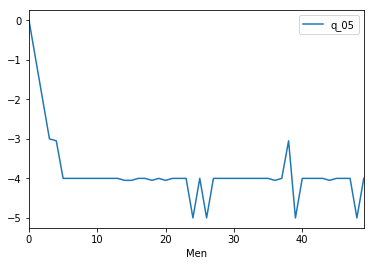

In [383]:
deliverable[(deliverable['n'] == 50)&(deliverable['sigma'] == .05)].plot(x='Men' ,y= 'q_05')


,n,sigma,Men,LRRW0,LRRW1,LRRW2,LRRW3,LRRW4,LRRW5,LRRW6,...,LRRW90,LRRW91,LRRW92,LRRW93,LRRW94,LRRW95,LRRW96,LRRW97,LRRW98,LRRW99
0,10,0.001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0.001,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0.001,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,10,0.001,3,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,10,0.001,4,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5,10,0.001,5,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
6,10,0.001,6,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
7,10,0.001,7,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
8,10,0.001,8,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
9,10,0.001,9,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8


In [45]:

#flatten the list:

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

flat_results = flatten(results) 

#Take group averages within the simulation
simulation_results = pd.DataFrame(flat_results,columns=['Market Size', 'Sigma','% Commonality' ])

gb = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' ]

simulation_results['Commonality SD'] = gb.transform('std')
simulation_results['Simulation Count'] = gb.transform('count')
deliverable = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' , 'Commonality SD', 'Simulation Count'].mean().reset_index()

deliverable

,Market Size,Sigma,% Commonality,Commonality SD,Simulation Count
0,10,0.001,1.000000,0.000000,1000
1,10,0.005,1.000000,0.000000,1000
2,10,0.010,1.000000,0.000000,1000
3,10,0.050,1.000000,0.000000,1000
4,10,0.100,0.987000,0.050927,1000
5,10,0.300,0.918400,0.125846,1000
6,50,0.001,1.000000,0.000000,1000
7,50,0.005,1.000000,0.000000,1000
8,50,0.010,0.999960,0.001265,1000
9,50,0.050,0.942360,0.048908,1000


NameError: name 'deliverable' is not defined

## Main Results:
The averaged results from the runs of this simulation for each parameter pair are plotted below. This suggests that there is not an obviously simple relationship between preference structure, market size, and the size of the core.

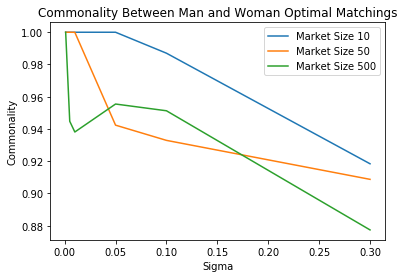

In [47]:
deliverable_10 = deliverable[deliverable['Market Size'] == 10]
deliverable_50 = deliverable[deliverable['Market Size'] == 50]
deliverable_500 = deliverable[deliverable['Market Size'] == 500]

plt.plot('Sigma', '% Commonality', data = deliverable_10, label = "Market Size 10")
plt.plot('Sigma', '% Commonality', data = deliverable_50, label = "Market Size 50")
plt.plot('Sigma', '% Commonality', data = deliverable_500, label = "Market Size 500")

plt.title("Commonality Between Man and Woman Optimal Matchings")
plt.xlabel('Sigma')
plt.ylabel('Commonality')
plt.legend()
plt.show()


### Data Structure Plot
To examine the structure of the data for the most interesting datapoints (size = 500, $\sigma$ = .01, .1), I form a histogram at those datapoints.  The averages do not appear to be driven by outliers, and they appear to have a similar data structure.

Text(0.5, 1.0, 'Distribution of Comonalities for Size = 500, Sigma = .01')

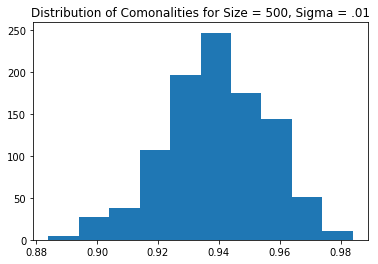

In [48]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .01 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .01")



Text(0.5, 1.0, 'Distribution of Comonalities for Size = 500, Sigma = .1')

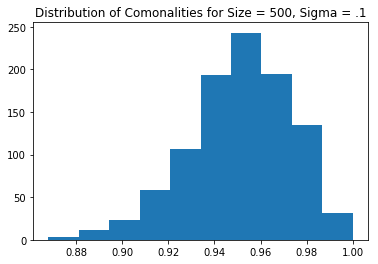

In [49]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .1 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .1")

## Granular results:
Finally, I show the basic summary statistics underlying the first plot:

In [50]:
deliverable

,Market Size,Sigma,% Commonality,Commonality SD,Simulation Count
0,10,0.001,1.000000,0.000000,1000
1,10,0.005,1.000000,0.000000,1000
2,10,0.010,1.000000,0.000000,1000
3,10,0.050,1.000000,0.000000,1000
4,10,0.100,0.987000,0.050927,1000
5,10,0.300,0.918400,0.125846,1000
6,50,0.001,1.000000,0.000000,1000
7,50,0.005,1.000000,0.000000,1000
8,50,0.010,0.999960,0.001265,1000
9,50,0.050,0.942360,0.048908,1000
